# Problem 1

## A. Optimization Comparisions

### Comparing SGD, SGD+Momentum, AdaGrad, RMSprop:
- Conventional Standard Gradient Descent (SGD)
    - Simplest method
    - Updates are solely based on learning rate and the current batch's gradient
    - ***Not Perfect:*** Gradient can get stuck in a local minima or a saddle point
    $$x \mathrel{+}= -lr * dx$$
- Standard Gradient Descent with **Momentum** (SGD+Momentum)
    - Adds a momentum component which can be used to carry some of the velocity of the weights
    - Velocity a decaying accumulation of the gradients
    - Aims to solve issue from SGD of getting stuck in minima or saddle 
    - Momentum aspect accelerate convergence, and dampens oscillations.
    $$v = \mu * v - lr * dx\\ x \mathrel{+}= v$$
    - adds v which is the velocity
    - adds $\mu$ which is the momentum normally set to $\mathrel{\approx}0.9$ 
- Adaptive Gradient (AdaGrad)
    - Element-wise adaptively adjust effective learning rate
        - for weights with high gradients: reduce
        - for weights with small/infrequent updates: increase
    $$cache \mathrel{+}= dx^2 \\ x \mathrel{+}= \frac{-lr * dx}{\sqrt{cache}+\epsilon}$$
    - $1\mathrm{e}{-8}<\epsilon<1\mathrm{e}{-4}$
    - $cache$: sum of squared gradients    
    - ***Not Perfect***: Cache increases causeing the effective learning rate to decreases, potentially causing learningto stop early
- Root Mean Squared Propagation  (RMSprop)
    - Builds on AdaGrad
    - Aims to solve gripes of AdaGrad by using an exponetially decaying moving average $cache$
    $$cache = decay * cache + (1-decay)*dx^2 \\  x \mathrel{+}= \frac{-lr * dx}{\sqrt{cache}+\epsilon} $$
    - $decay$ is typically $0.9, 0.99, 0.999 ...$
    - Prevents the learning rate from vanishing too quickly, allowing for continued learning

### Popularity of Adam
- Adam's popularity comes because it does the adaptive learning rate from RMSprop and also brings in the momentum aspect from SGD+Momentum.
- These features allow adam to be able to navigate complex loss landscapes
- It converges faster, being more efficient and compute friendly
- These factors and the effectiveness across various tasks such as NLP, and computer vision has led to it wide spread adoption in the field.



## B. Implementations

### Imports and datasets

In [3]:
# Load in relevant libraries, and alias where appropriate
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time

# Define relevant variables for the ML task
batch_size = 256
learning_rate = 0.01
num_epochs = 10 # 20 just gets almost 100 everytime

# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# For training data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST standard mean and standard deviation
])

cifar_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# For test data
cifar_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)


# DataLoader for training and test datasets
trainloader = torch.utils.data.DataLoader(cifar_trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(cifar_testset, batch_size=batch_size, shuffle=False)

### Model

In [4]:
class MLP:
    def __init__(self):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 200),
            nn.ReLU(),
            nn.Linear(200, 50),
            nn.ReLU(),
            nn.Linear(50, 10)
            # nn.Softmax(dim=1) # Not needed for CrossEntropyLoss
        )

    def forward(self, x):
        return self.net(x)

model = MLP().net.to(device)
criterion = nn.CrossEntropyLoss() # Loss function

### Train and Test Funcitons

In [5]:
def train(optimizer, name = 'err', scheduler=None, model=model, trainloader=trainloader, num_epochs=num_epochs):
    start_time = time.time()
    criterion = nn.CrossEntropyLoss()
    # Lists to store losses for plotting
    epoch_losses = []
    
    # Training loop
    for epoch in range(num_epochs):
        # Set model to training mode
        model.train()
        
        running_loss = 0.0
        batches_in_epoch = 0
        
        for i, (inputs, labels) in enumerate(trainloader):
            # Move data to device (CPU/GPU)
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Accumulate statistics
            running_loss += loss.item()
            batches_in_epoch += 1
        
        # Step the scheduler if it exists
        if scheduler is not None:
            scheduler.step()
        
        # Store average loss for this epoch
        avg_epoch_loss = running_loss / batches_in_epoch
        epoch_losses.append(avg_epoch_loss)
        print(f'Epoch {epoch + 1}, Loss: {avg_epoch_loss:.3f}')
    
    # Plot the training loss
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o')
    plt.title('Training Loss Over Epochs for MLP' + name)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Training completed in {elapsed_time:.2f} seconds")
    

def test(model = model, testloader=testloader):
    start_time = time.time()
    # Testing the best model on test data
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f'testing finished in {elapsed_time:.2f} seconds, Accuracy: {accuracy:.2f}%')
    return accuracy

def train_test(optimizer:torch.optim, name = 'err', scheduler=None):
    train(optimizer=optimizer, name=name, scheduler=scheduler)
    return test()

### Implementations


Training with optimiser: sgd, lr_scheduler: None
Epoch 1, Loss: 1.683
Epoch 2, Loss: 0.661
Epoch 3, Loss: 0.443
Epoch 4, Loss: 0.373
Epoch 5, Loss: 0.338
Epoch 6, Loss: 0.313
Epoch 7, Loss: 0.294
Epoch 8, Loss: 0.279
Epoch 9, Loss: 0.265
Epoch 10, Loss: 0.253


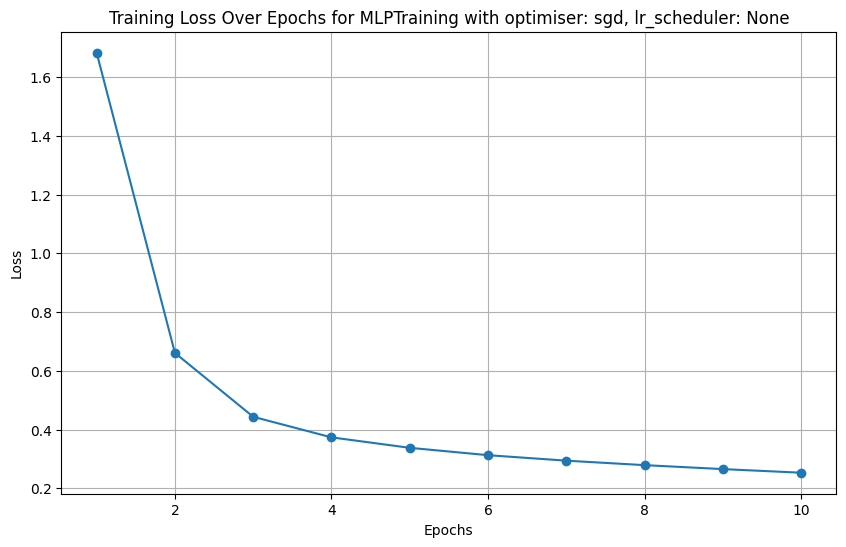

Training completed in 75.73 seconds
testing finished in 1.17 seconds, Accuracy: 93.08%
Training with optimiser: sgd, lr_scheduler: StepLR
Epoch 1, Loss: 0.242
Epoch 2, Loss: 0.232
Epoch 3, Loss: 0.225
Epoch 4, Loss: 0.224
Epoch 5, Loss: 0.223
Epoch 6, Loss: 0.223
Epoch 7, Loss: 0.223
Epoch 8, Loss: 0.223
Epoch 9, Loss: 0.223
Epoch 10, Loss: 0.223


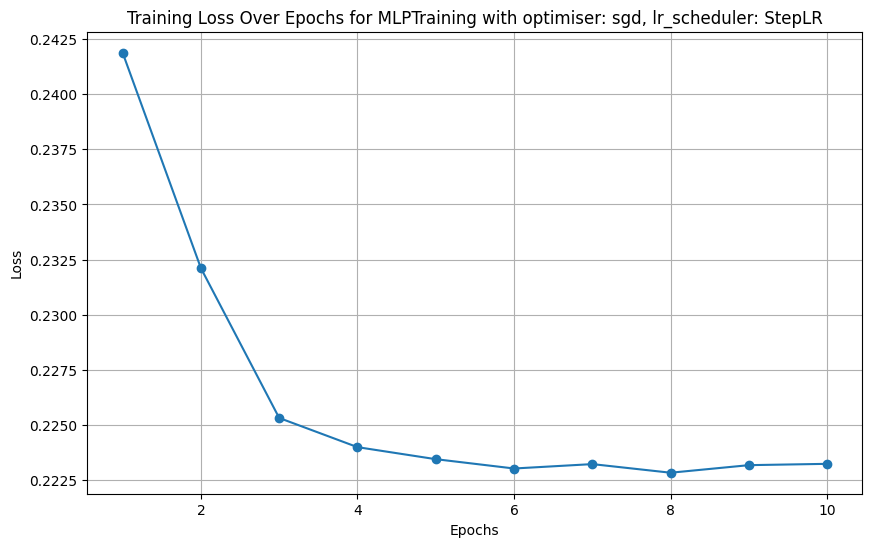

Training completed in 70.56 seconds
testing finished in 0.58 seconds, Accuracy: 93.64%
Training with optimiser: sgd, lr_scheduler: CosineAnnealingLR
Epoch 1, Loss: 0.223
Epoch 2, Loss: 0.223
Epoch 3, Loss: 0.223
Epoch 4, Loss: 0.223
Epoch 5, Loss: 0.223
Epoch 6, Loss: 0.223
Epoch 7, Loss: 0.223
Epoch 8, Loss: 0.223
Epoch 9, Loss: 0.223
Epoch 10, Loss: 0.223


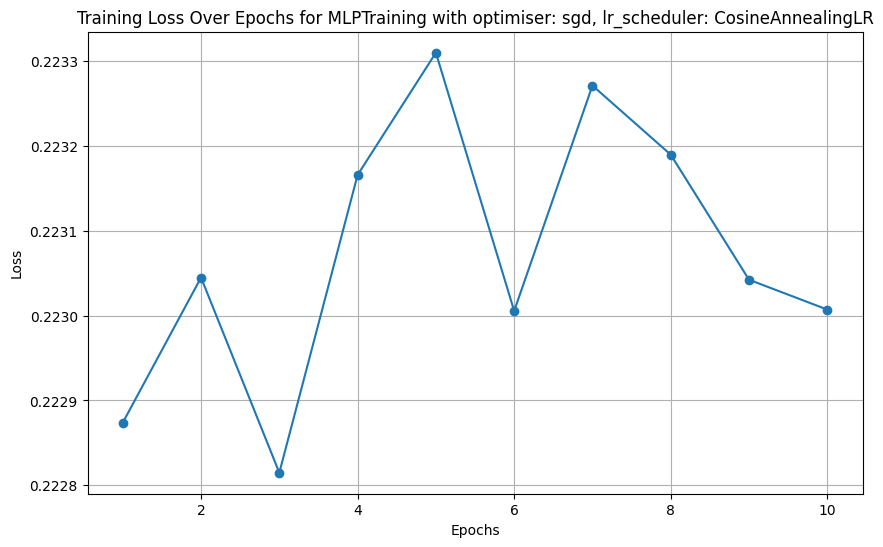

Training completed in 35.74 seconds
testing finished in 0.58 seconds, Accuracy: 93.64%
Training with optimiser: sgd_momentum, lr_scheduler: None
Epoch 1, Loss: 0.204
Epoch 2, Loss: 0.153
Epoch 3, Loss: 0.121
Epoch 4, Loss: 0.097
Epoch 5, Loss: 0.082
Epoch 6, Loss: 0.071
Epoch 7, Loss: 0.060
Epoch 8, Loss: 0.053
Epoch 9, Loss: 0.046
Epoch 10, Loss: 0.041


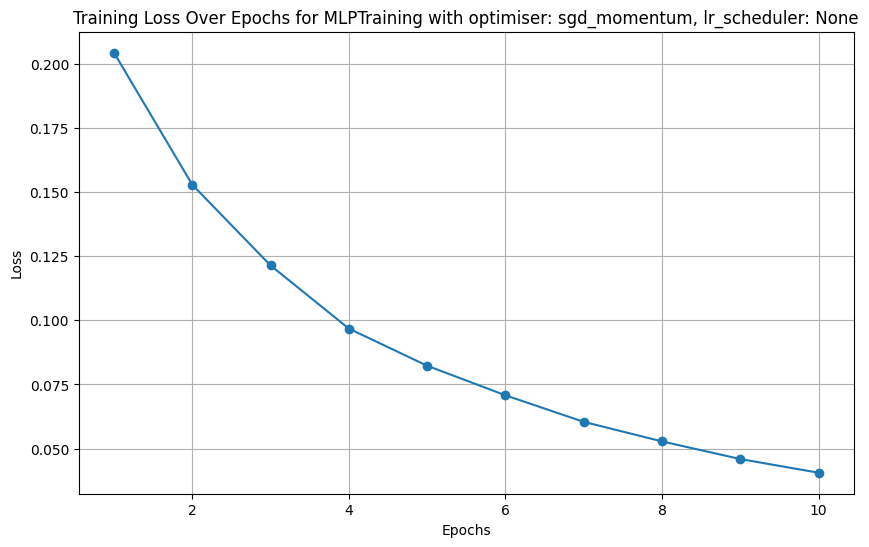

Training completed in 34.97 seconds
testing finished in 0.55 seconds, Accuracy: 97.90%
Training with optimiser: sgd_momentum, lr_scheduler: StepLR
Epoch 1, Loss: 0.035
Epoch 2, Loss: 0.031
Epoch 3, Loss: 0.023
Epoch 4, Loss: 0.022
Epoch 5, Loss: 0.021
Epoch 6, Loss: 0.021
Epoch 7, Loss: 0.021
Epoch 8, Loss: 0.021
Epoch 9, Loss: 0.021
Epoch 10, Loss: 0.021


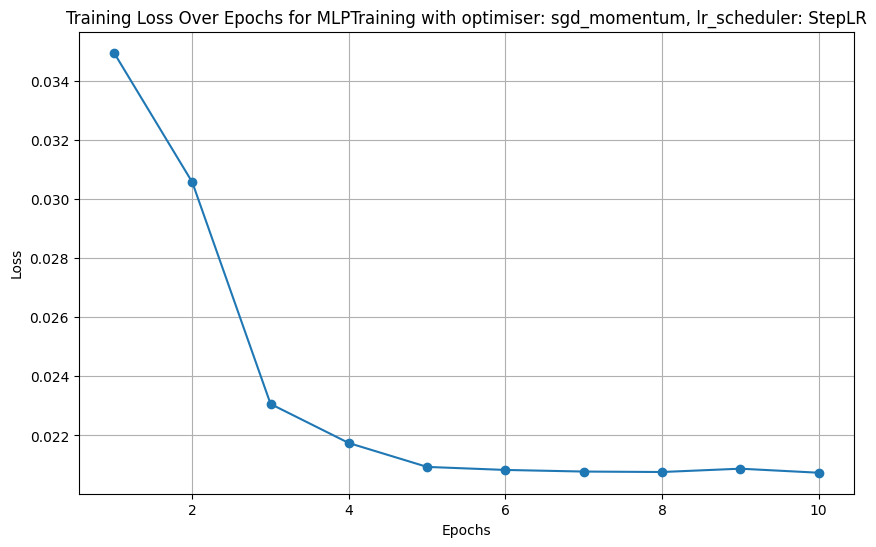

Training completed in 34.88 seconds
testing finished in 0.56 seconds, Accuracy: 97.91%
Training with optimiser: sgd_momentum, lr_scheduler: CosineAnnealingLR
Epoch 1, Loss: 0.021
Epoch 2, Loss: 0.021
Epoch 3, Loss: 0.021
Epoch 4, Loss: 0.021
Epoch 5, Loss: 0.021
Epoch 6, Loss: 0.021
Epoch 7, Loss: 0.021
Epoch 8, Loss: 0.021
Epoch 9, Loss: 0.021
Epoch 10, Loss: 0.021


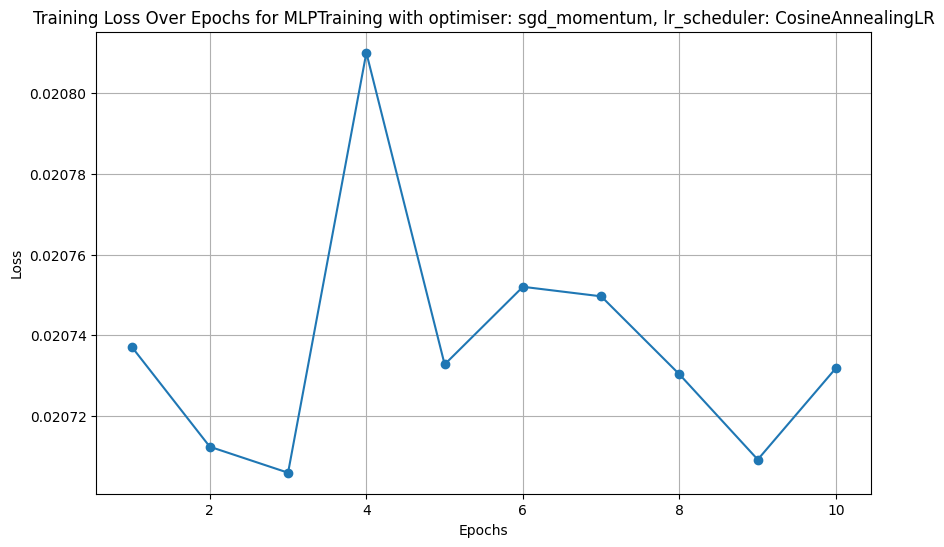

Training completed in 34.39 seconds
testing finished in 0.55 seconds, Accuracy: 97.91%
Training with optimiser: adagrad, lr_scheduler: None
Epoch 1, Loss: 0.316
Epoch 2, Loss: 0.046
Epoch 3, Loss: 0.035
Epoch 4, Loss: 0.027
Epoch 5, Loss: 0.022
Epoch 6, Loss: 0.019
Epoch 7, Loss: 0.017
Epoch 8, Loss: 0.015
Epoch 9, Loss: 0.013
Epoch 10, Loss: 0.012


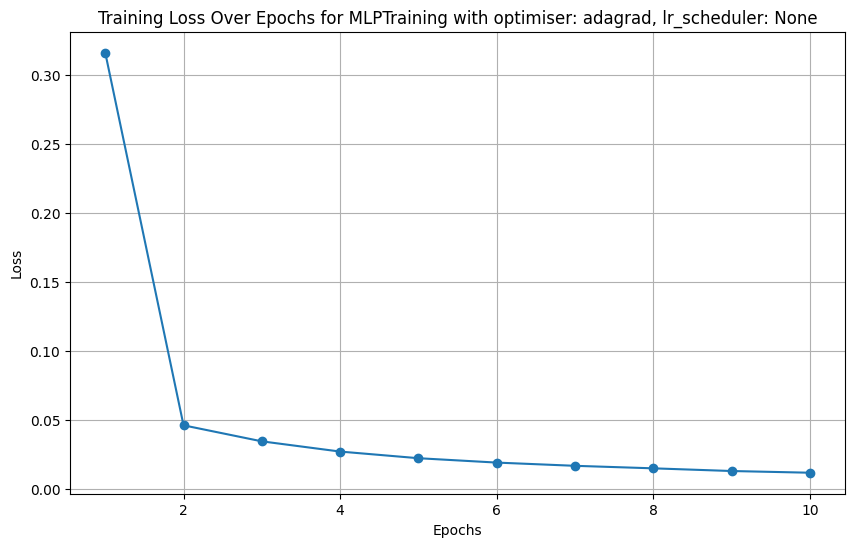

Training completed in 34.67 seconds
testing finished in 0.55 seconds, Accuracy: 98.02%
Training with optimiser: adagrad, lr_scheduler: StepLR
Epoch 1, Loss: 0.011
Epoch 2, Loss: 0.010
Epoch 3, Loss: 0.008
Epoch 4, Loss: 0.008
Epoch 5, Loss: 0.008
Epoch 6, Loss: 0.008
Epoch 7, Loss: 0.008
Epoch 8, Loss: 0.008
Epoch 9, Loss: 0.008
Epoch 10, Loss: 0.008


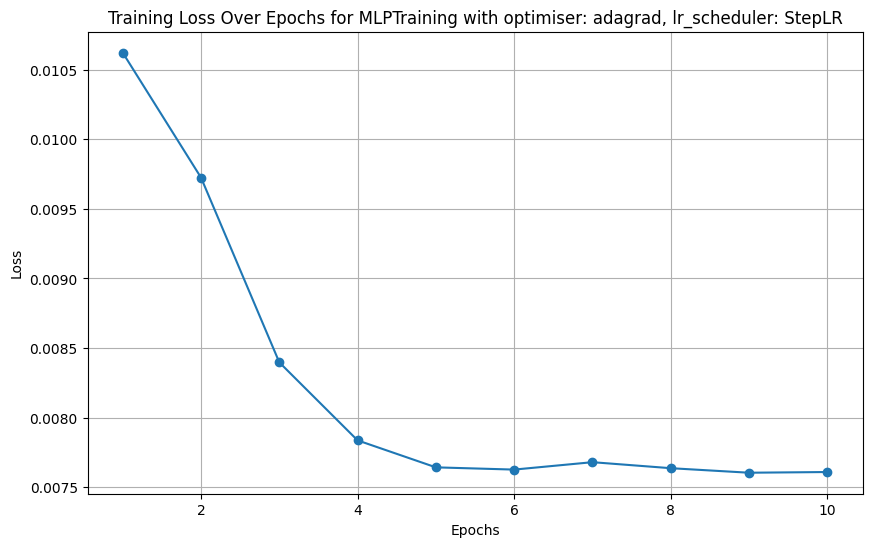

Training completed in 34.51 seconds
testing finished in 0.55 seconds, Accuracy: 97.98%
Training with optimiser: adagrad, lr_scheduler: CosineAnnealingLR
Epoch 1, Loss: 0.008
Epoch 2, Loss: 0.008
Epoch 3, Loss: 0.008
Epoch 4, Loss: 0.008
Epoch 5, Loss: 0.008
Epoch 6, Loss: 0.008
Epoch 7, Loss: 0.008
Epoch 8, Loss: 0.008
Epoch 9, Loss: 0.008
Epoch 10, Loss: 0.008


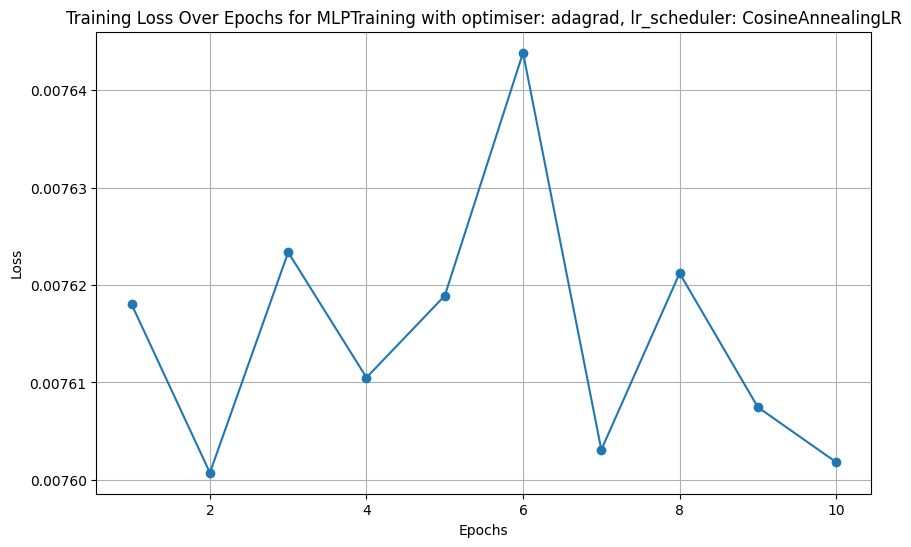

Training completed in 35.15 seconds
testing finished in 0.56 seconds, Accuracy: 97.98%
Training with optimiser: rmsprop, lr_scheduler: None
Epoch 1, Loss: 0.974
Epoch 2, Loss: 0.190
Epoch 3, Loss: 0.156
Epoch 4, Loss: 0.140
Epoch 5, Loss: 0.128
Epoch 6, Loss: 0.120
Epoch 7, Loss: 0.117
Epoch 8, Loss: 0.108
Epoch 9, Loss: 0.106
Epoch 10, Loss: 0.104


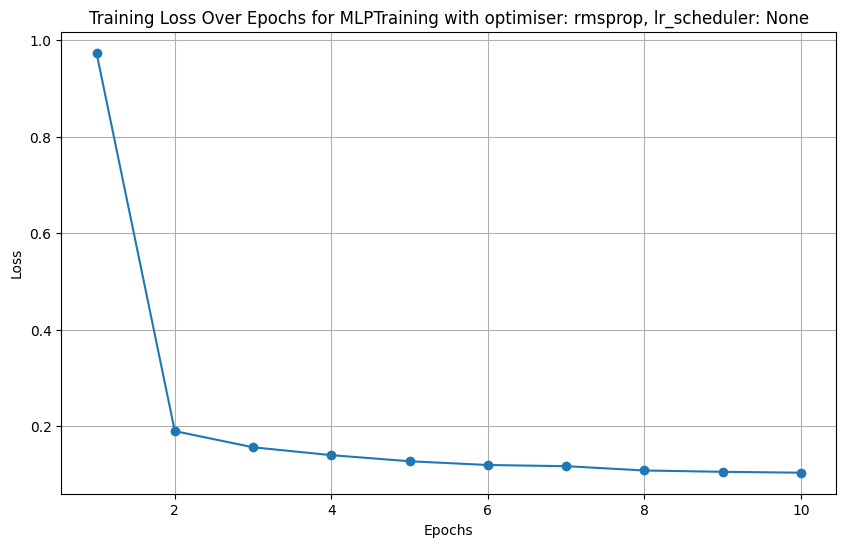

Training completed in 35.31 seconds
testing finished in 0.57 seconds, Accuracy: 96.61%
Training with optimiser: rmsprop, lr_scheduler: StepLR
Epoch 1, Loss: 0.092
Epoch 2, Loss: 0.093
Epoch 3, Loss: 0.047
Epoch 4, Loss: 0.026
Epoch 5, Loss: 0.019
Epoch 6, Loss: 0.018
Epoch 7, Loss: 0.017
Epoch 8, Loss: 0.017
Epoch 9, Loss: 0.017
Epoch 10, Loss: 0.017


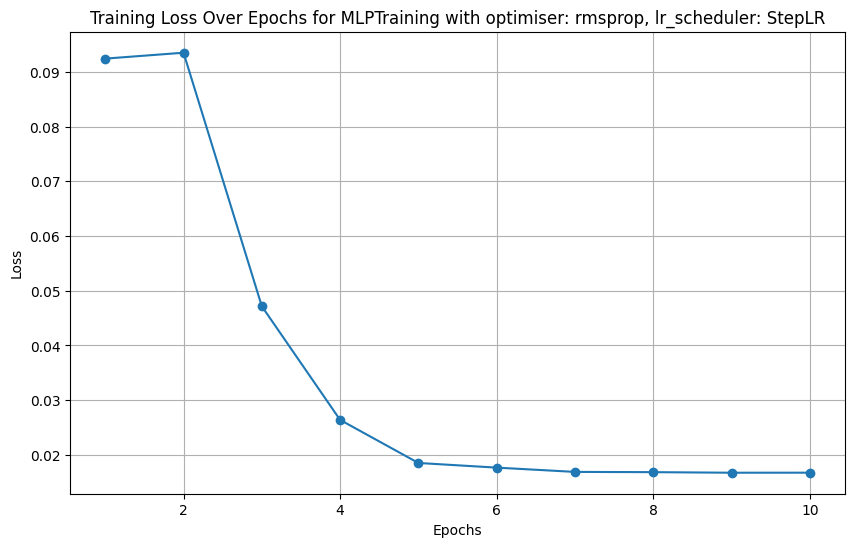

Training completed in 35.50 seconds
testing finished in 0.59 seconds, Accuracy: 97.82%
Training with optimiser: rmsprop, lr_scheduler: CosineAnnealingLR
Epoch 1, Loss: 0.017
Epoch 2, Loss: 0.017
Epoch 3, Loss: 0.017
Epoch 4, Loss: 0.017
Epoch 5, Loss: 0.017
Epoch 6, Loss: 0.017
Epoch 7, Loss: 0.017
Epoch 8, Loss: 0.017
Epoch 9, Loss: 0.017
Epoch 10, Loss: 0.017


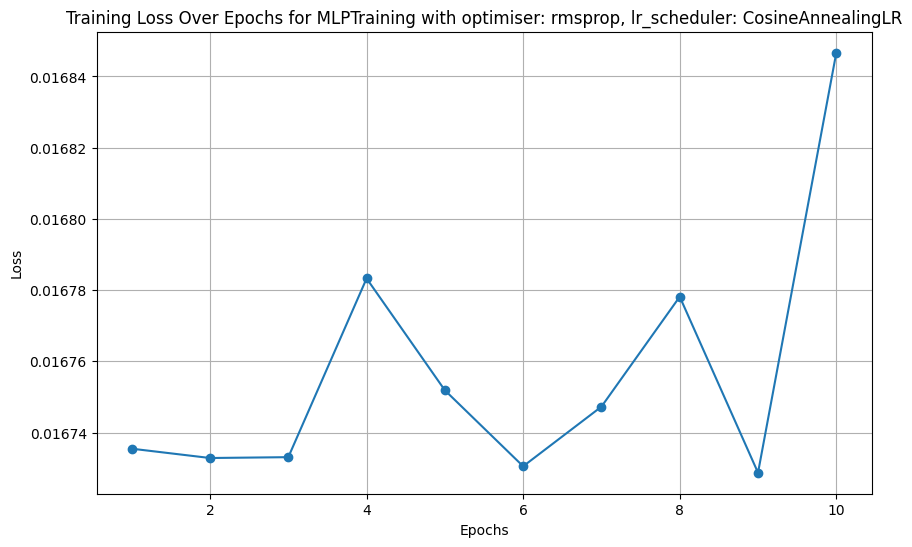

Training completed in 35.52 seconds
testing finished in 0.56 seconds, Accuracy: 97.82%
Training with optimiser: adam, lr_scheduler: None
Epoch 1, Loss: 0.107
Epoch 2, Loss: 0.079
Epoch 3, Loss: 0.077
Epoch 4, Loss: 0.051
Epoch 5, Loss: 0.055
Epoch 6, Loss: 0.064
Epoch 7, Loss: 0.053
Epoch 8, Loss: 0.056
Epoch 9, Loss: 0.044
Epoch 10, Loss: 0.056


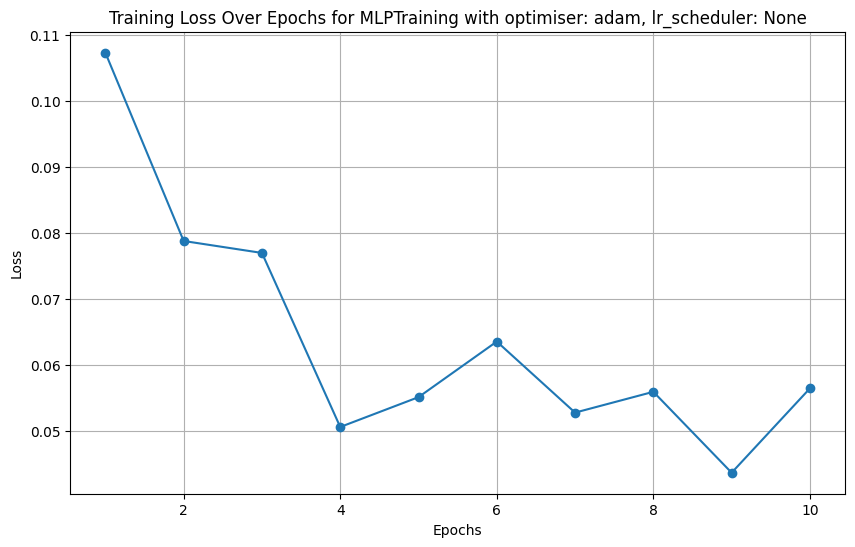

Training completed in 35.28 seconds
testing finished in 0.55 seconds, Accuracy: 96.93%
Training with optimiser: adam, lr_scheduler: StepLR
Epoch 1, Loss: 0.052
Epoch 2, Loss: 0.057
Epoch 3, Loss: 0.027
Epoch 4, Loss: 0.015
Epoch 5, Loss: 0.012
Epoch 6, Loss: 0.011
Epoch 7, Loss: 0.011
Epoch 8, Loss: 0.011
Epoch 9, Loss: 0.011
Epoch 10, Loss: 0.011


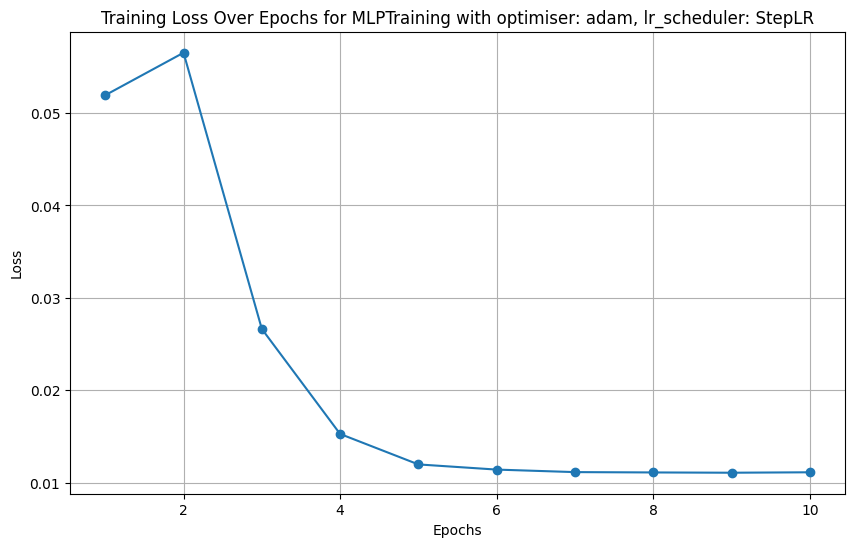

Training completed in 34.74 seconds
testing finished in 0.56 seconds, Accuracy: 97.81%
Training with optimiser: adam, lr_scheduler: CosineAnnealingLR
Epoch 1, Loss: 0.011
Epoch 2, Loss: 0.011
Epoch 3, Loss: 0.011
Epoch 4, Loss: 0.011
Epoch 5, Loss: 0.011
Epoch 6, Loss: 0.011
Epoch 7, Loss: 0.011
Epoch 8, Loss: 0.011
Epoch 9, Loss: 0.011
Epoch 10, Loss: 0.011


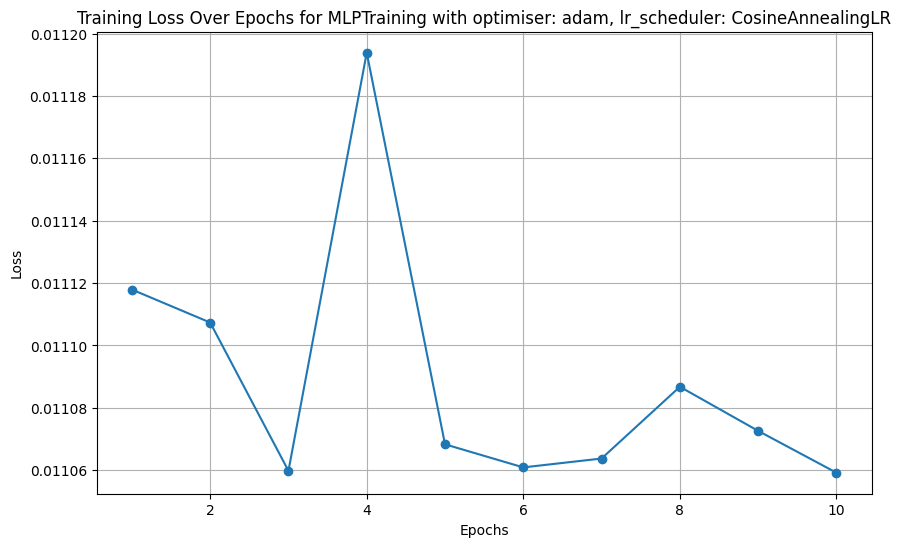

Training completed in 34.78 seconds
testing finished in 0.56 seconds, Accuracy: 97.81%


In [6]:
optimizers = {
    'sgd': torch.optim.SGD(model.parameters(), lr=learning_rate),
    'sgd_momentum': torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9),
    'adagrad': torch.optim.Adagrad(model.parameters(), lr=learning_rate, eps=1e-6),
    'rmsprop': torch.optim.RMSprop(model.parameters(), lr=learning_rate, alpha=0.9, eps=1e-6),
    'adam': torch.optim.Adam(model.parameters(), lr=learning_rate)
}
results = {}
def try_all(optimizers = optimizers):
    for optimizer in optimizers:
        optim = optimizers[optimizer]
        print_out = f"Training with optimiser: {optimizer}, lr_scheduler: None"
        print(print_out)
        results[print_out] = train_test(optim, name=print_out)
        print_out = f"Training with optimiser: {optimizer}, lr_scheduler: StepLR"
        print(print_out)
        results[print_out] = train_test(optim, name=print_out, scheduler=torch.optim.lr_scheduler.StepLR(optimizers[optimizer], step_size=2, gamma=0.1))
        print_out = f"Training with optimiser: {optimizer}, lr_scheduler: CosineAnnealingLR"
        print(print_out)
        results[print_out] = train_test(optim, name=print_out, scheduler=torch.optim.lr_scheduler.CosineAnnealingLR(optimizers[optimizer], T_max=10))
                

try_all()

### At the end of it all

In [7]:
for result in results:
    print(f"After {result}, Accuracy: {results[result]}")

After Training with optimiser: sgd, lr_scheduler: None, Accuracy: 93.08
After Training with optimiser: sgd, lr_scheduler: StepLR, Accuracy: 93.64
After Training with optimiser: sgd, lr_scheduler: CosineAnnealingLR, Accuracy: 93.64
After Training with optimiser: sgd_momentum, lr_scheduler: None, Accuracy: 97.9
After Training with optimiser: sgd_momentum, lr_scheduler: StepLR, Accuracy: 97.91
After Training with optimiser: sgd_momentum, lr_scheduler: CosineAnnealingLR, Accuracy: 97.91
After Training with optimiser: adagrad, lr_scheduler: None, Accuracy: 98.02
After Training with optimiser: adagrad, lr_scheduler: StepLR, Accuracy: 97.98
After Training with optimiser: adagrad, lr_scheduler: CosineAnnealingLR, Accuracy: 97.98
After Training with optimiser: rmsprop, lr_scheduler: None, Accuracy: 96.61
After Training with optimiser: rmsprop, lr_scheduler: StepLR, Accuracy: 97.82
After Training with optimiser: rmsprop, lr_scheduler: CosineAnnealingLR, Accuracy: 97.82
After Training with optimi

### Write-up
I wrote a loop to run through all the models, and per model it runs every learning rate scheduler.
I tried a few different values for num_epochs, I found that using 20 epochs always ended up giving really high accuracy so I was not able to tell a difference. I stuck with 10 to create more of a difference.

#### Findings
Comparing the optimizers I found that SGD (Stochastic Gradient Descent) performed relatively poorly with an accuracy of around 93-94%. Adding momentum to SGD (SGD with momentum) significantly improved the results, reaching around 97-98% accuracy. Adagrad did even better, consistently achieving about 98.13% accuracy. RMSProp and Adam fell somewhere in between, with accuracies around 95-98%.

Comparing the learning rate schedulers, StepLR and CosineAnnealingLR generally helped improve or maintain the accuracy compared to having no scheduler. However, with optimizers like Adagrad, the scheduler didn't seem to make a difference. Overall, using SGD with momentum or Adagrad seemed to yield the best results, especially when combined with a scheduler like StepLR or CosineAnnealingLR.





# Problem 2

Epoch [100/4000], MLP Loss: 0.1005, Fourier Loss: 0.1595
Epoch [200/4000], MLP Loss: 0.0425, Fourier Loss: 0.0520
Epoch [300/4000], MLP Loss: 0.0393, Fourier Loss: 0.0407
Epoch [400/4000], MLP Loss: 0.0397, Fourier Loss: 0.0395
Epoch [500/4000], MLP Loss: 0.0385, Fourier Loss: 0.0388
Epoch [600/4000], MLP Loss: 0.0381, Fourier Loss: 0.0382
Epoch [700/4000], MLP Loss: 0.0379, Fourier Loss: 0.0373
Epoch [800/4000], MLP Loss: 0.0375, Fourier Loss: 0.0356
Epoch [900/4000], MLP Loss: 0.0381, Fourier Loss: 0.0382
Epoch [1000/4000], MLP Loss: 0.0369, Fourier Loss: 0.0298
Epoch [1100/4000], MLP Loss: 0.0362, Fourier Loss: 0.0266
Epoch [1200/4000], MLP Loss: 0.0324, Fourier Loss: 0.0223
Epoch [1300/4000], MLP Loss: 0.0299, Fourier Loss: 0.0220
Epoch [1400/4000], MLP Loss: 0.0281, Fourier Loss: 0.0188
Epoch [1500/4000], MLP Loss: 0.0267, Fourier Loss: 0.0146
Epoch [1600/4000], MLP Loss: 0.0262, Fourier Loss: 0.0131
Epoch [1700/4000], MLP Loss: 0.0264, Fourier Loss: 0.0126
Epoch [1800/4000], MLP 

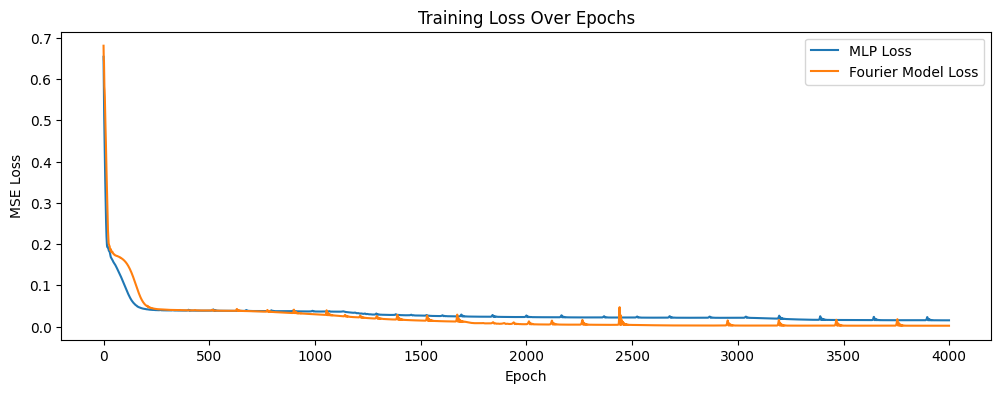

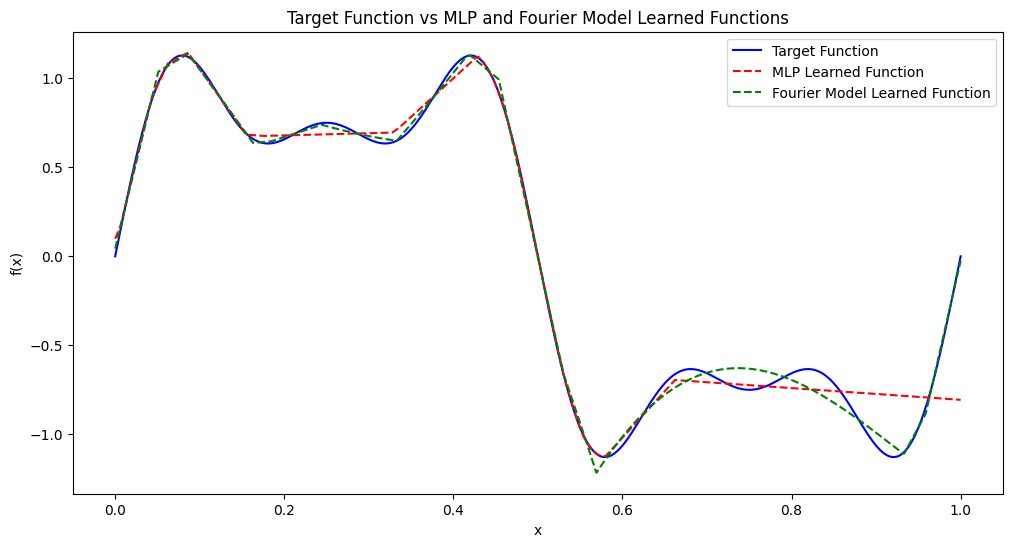

In [8]:
# Import necessary libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Set seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Define the target function as the sum of 3 sinusoids
def target_function(x):
    return np.sin(2 * np.pi * 1.0 * x) + 0.5 * np.sin(2 * np.pi * 3.0 * x) + 0.25 * np.sin(2 * np.pi * 5.0 * x)

# Generate dataset with 4000 points
x = np.linspace(0, 1, 4000)  # 4000 points between 0 and 1
y = target_function(x)

# Convert to PyTorch tensors
x_train = torch.tensor(x, dtype=torch.float32).view(-1, 1)
y_train = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# Define the original 3-layer MLP model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(1, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 1)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        return self.fc3(x)

# Define the LFF (Learnable Fourier Feature) layer
class LFF(nn.Module):
    def __init__(self, in_features, out_features, scale=1.0, init="iso", sincos=False):
        super().__init__()
        self.in_features = in_features
        self.sincos = sincos
        self.out_features = out_features
        self.scale = scale
        if self.sincos:
            self.linear = nn.Linear(in_features, out_features // 2)
        else:
            self.linear = nn.Linear(in_features, out_features)
        if init == "iso":
            nn.init.normal_(self.linear.weight, 0, scale / in_features)
            nn.init.normal_(self.linear.bias, 0, 1)
        else:
            nn.init.uniform_(self.linear.weight, -scale / in_features, scale / in_features)
            nn.init.uniform_(self.linear.bias, -1, 1)
        if self.sincos:
            nn.init.zeros_(self.linear.bias)

    def forward(self, x):
        x = np.pi * self.linear(x)
        if self.sincos:
            return torch.cat([torch.sin(x), torch.cos(x)], dim=-1)
        else:
            return torch.sin(x)

# Define the FourierModel with the LFF layer
class FourierModel(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim):
        super(FourierModel, self).__init__()
        self.input_layer = LFF(state_dim, hidden_dim, scale=0.1, init="iso", sincos=False)
        self.mid_layer = nn.Linear(hidden_dim, hidden_dim)
        self.relu2 = nn.ReLU()
        self.output = nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.mid_layer(x)
        x = self.relu2(x)
        return self.output(x)

# Initialize models, loss function, and optimizers
mlp_model = MLP()
fourier_model = FourierModel(state_dim=1, action_dim=1, hidden_dim=100)

criterion = nn.MSELoss()
mlp_optimizer = optim.Adam(mlp_model.parameters(), lr=0.002)
fourier_optimizer = optim.Adam(fourier_model.parameters(), lr=0.002)

# Training loop for both models
num_epochs = 4000
mlp_losses = []
fourier_losses = []

for epoch in range(num_epochs):
    # Train MLP model
    mlp_model.train()
    mlp_optimizer.zero_grad()
    mlp_y_pred = mlp_model(x_train)
    mlp_loss = criterion(mlp_y_pred, y_train)
    mlp_loss.backward()
    mlp_optimizer.step()
    mlp_losses.append(mlp_loss.item())

    # Train Fourier model
    fourier_model.train()
    fourier_optimizer.zero_grad()
    fourier_y_pred = fourier_model(x_train)
    fourier_loss = criterion(fourier_y_pred, y_train)
    fourier_loss.backward()
    fourier_optimizer.step()
    fourier_losses.append(fourier_loss.item())

    # Print loss every 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], MLP Loss: {mlp_loss.item():.4f}, Fourier Loss: {fourier_loss.item():.4f}")

# Plot the training loss for both models
plt.figure(figsize=(12, 4))
plt.plot(mlp_losses, label="MLP Loss")
plt.plot(fourier_losses, label="Fourier Model Loss")
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

# Plot the target function vs. the learned functions
with torch.no_grad():
    mlp_y_learned = mlp_model(x_train).numpy()
    fourier_y_learned = fourier_model(x_train).numpy()

plt.figure(figsize=(12, 6))
plt.plot(x, y, label="Target Function", color='blue')
plt.plot(x, mlp_y_learned, label="MLP Learned Function", color='red', linestyle='--')
plt.plot(x, fourier_y_learned, label="Fourier Model Learned Function", color='green', linestyle='--')
plt.title("Target Function vs MLP and Fourier Model Learned Functions")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.show()

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


- What is the input and output of the model? What does this code do?
    - **MLP Model**      
        - **Input:** Takes in a sample of shape: 1
        - **Output:** ouptuts a sample of shape: 1
    - **Fourier Loss**     
        - **Input:** Takes in a sample of shape: 1    
        - **Output:** ouptuts a sample of shape: 1     
    The code trains the aforementioned neural networks to approximate a target function. it then compares their losses, then compares the learned functions to the target function.

- What a role does the LFF layer shown in the code play? Explain briefly.    
    The LFF (Learnable Fourier Feature) layer transforms the input into a higher-dimensional space using sine functions (since sincos=False). This transformation helps the model represnt the sample's in higher dimensionality, this allows the model to train on the frequencies and amplitudes generated. Here `sincos` is set to `False` without this it would generate both $[sin(W_n X_n), cos(W_n x_n)]$, using only $sin(W_n x_n)$ is beneficial for simplicity and can be effective for capturing periodic patterns in the dataset.

- Run the code and describe what you observe. How do the results relate to the Universal Function Approximation Theorem of neural networks?    
    **Observations**    
    We can observe that both the learned functions are very similar to the target function. Although the LFF funciton is much closer to the target funciton. This behavior might be because of the fourier features being in a higher dimentionality, allowing for better feature detection for samples with lower complexities.    
    **universal approximation theorem states**     
    The *universal approximation theorem states* that any continuous function $f$ can be approximated arbitrarily well by a neural network with at least 1 hidden layer with a finite number of weights [[source]](https://mitliagkas.github.io/ift6085-2020/ift-6085-lecture-10-notes.pdf).    
    **How Observations relate to UAT**  
    The similarity between the observations and the UAT demonstrate the theorem in practice. increaseing the number of weights and representing the samples in a higher dimentionality can prove to be effective for funciton approximators.

